In [ ]:
# %%
import region_analysis_per_neuron 
from cube_analysis_per_neuron_terminal import cube_analysis_per_neuron_terminal

import neuro_tracer as nt

import sys,os

from collections import defaultdict

from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import nibabel as nib  
import pandas as pd
from typing import Tuple
from io import StringIO

import seaborn as sns
import matplotlib.cm as cm
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage

import csv

import gc
neurovis_path = os.path.abspath(r'D:\projectome_analysis\neuron-vis\neuronVis')
sys.path.append(neurovis_path)

import IONData 
iondata = IONData.IONData()

c:\Users\binbi\anaconda3\envs\neuronVis\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\binbi\anaconda3\envs\neuronVis\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\binbi\anaconda3\envs\neuronVis\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Getting the CT neurons

In [4]:
# %%
filename = '../resources/SubtypeInfo.txt'
neuron_list = {}

columns = ['expid', 'neuronid', 'subtype']

pfc_neuron_list=pd.read_csv(filename, sep=' ',names=columns,header=None,dtype={'expid':str,'neuronid':str,'subtype':int})
ct_ids = list(range(45,53))
ct_neuron_list = pfc_neuron_list[pfc_neuron_list['subtype'].isin(ct_ids)]

ct_neuron_list.reset_index(inplace=True,drop=True)

# Load CFF Atlas and Its Labels
- Acquire the dimensional information of the atlas
- Extract the label-voxel index information with dataframe for the next target region (MD) extraction

In [3]:
# %%
atlas_base_path = Path(r'D:\Monkey_projectome_training\resources\atlas\mouse')
cff_atlas_path = atlas_base_path / r"annotation_10.nii.gz"
cff_atlas= nib.load(cff_atlas_path)
cff_labels = pd.read_csv(os.path.join(atlas_base_path, 'parcellation_term.csv'),sep=',',header=0,usecols=[0,1,2])
cff_labels['label'] = cff_labels['label'].str.split('-').str[-1]
cff_index  = pd.read_csv(os.path.join(atlas_base_path, 'parcellation.csv'),sep=',',header=0,usecols=[0,1])
cff_index['label']=cff_index['label'].str.split('-').str[-1]
cff_table = pd.merge(cff_index,cff_labels,left_on='label',right_on='label')
cff_voxels = cff_atlas.get_fdata()
print(cff_voxels.shape)

print(f'the parameter for swc to nii is shape {cff_voxels.shape},reso {cff_atlas.header.get_zooms()}')

(1320, 800, 1140)
the parameter for swc to nii is shape (1320, 800, 1140),reso (0.01, 0.01, 0.01)


# Extract Target Region Volume

- Figure 5 is based on the MD nucleus the thalamus, find the voxel value from the table, then extract the volume
- Save the extracted volume as a nifti file

In [ ]:
# %%
target_region = 'Mediodorsal'
region_output_path = atlas_base_path / rf"extracted_{target_region}_volume.nii.gz"

if region_output_path.exists():
    pass
else:
    
    region_index = cff_table[cff_table['name'].str.contains(rf'\b{target_region}',case=False)]['parcellation_index'].tolist()

    region_mask=np.isin(cff_voxels,region_index)
    region_voxels = np.where(region_mask, cff_voxels, 0) # if not region indices, set to 0

    region_img = nib.Nifti1Image(region_voxels, cff_atlas.affine, cff_atlas.header)

    nib.save(region_img, region_output_path)
    
    del cff_voxels, region_voxels, region_mask # free up memory 
gc.collect()

30

# Subdivide Volume into Cubes

paper method used 100 micron sized cubes to subdivide the volume.
so we create isotropic cubes of 100 micron dimensions.

the first function below loads the extracted volume and generate a list of cubes in terms of their start and end coordinates ( their difference will mark the region of each cubes).

there is also a helper function to show the edges of the cubes for QC

In [6]:
#%%
def subdivide_volume_into_cubes(nifti_path, cube_size_mm=0.1,save=True):
    """
    Subdivide a NIfTI volume into cubes of specified physical size and identify those intersecting the region of interest.
    
    Parameters:
    - nifti_path (str): Path to the NIfTI file (e.g., thalamus mask).
    - cube_size_mm (float): Desired cube size in millimeters (default: 0.1 mm, i.e., 100 μm).
    
    Returns:
    - list: List of dictionaries with 'start' and 'end' coordinates (in voxel space) for cubes intersecting the volume.
    - tuple: Voxel size in mm (x, y, z) from the NIfTI header.
    - int: Cube size in voxels (assuming isotropic voxels for simplicity).
    """
    
    # Load the NIfTI file
    img = nib.load(nifti_path)
    data = img.get_fdata()  # 3D array of voxel values
    
    # Get voxel size in mm from the header
    voxel_size = img.header.get_zooms()  # (x, y, z) in mm
    if not np.allclose(voxel_size[0], voxel_size[1:], rtol=1e-5):
        print("Warning: Voxel sizes are anisotropic. Using x-dimension size for cube calculation.")
    voxel_size_mm = voxel_size[0]  # Assume isotropic for cube size calculation
    
    # Calculate cube size in voxels
    cube_voxels = int(cube_size_mm / voxel_size_mm)
    if cube_voxels == 0:
        raise ValueError(f"Cube size ({cube_size_mm} mm) is smaller than voxel size ({voxel_size_mm} mm).")
    print(f"Cube size in voxels: {cube_voxels} (based on {cube_size_mm} mm / {voxel_size_mm} mm voxel size)")
    
    # Find the bounding box of the region of interest (non-zero voxels)
    indices = np.nonzero(data)
    if len(indices[0]) == 0:
        raise ValueError("No non-zero voxels found in the volume.")
    
    x_min, x_max = np.min(indices[0]), np.max(indices[0])
    y_min, y_max = np.min(indices[1]), np.max(indices[1])
    z_min, z_max = np.min(indices[2]), np.max(indices[2])
    
    # Adjust bounding box to align with cube boundaries
    x_min = (x_min // cube_voxels) * cube_voxels
    x_max = ((x_max // cube_voxels) + 1) * cube_voxels
    y_min = (y_min // cube_voxels) * cube_voxels
    y_max = ((y_max // cube_voxels) + 1) * cube_voxels
    z_min = (z_min // cube_voxels) * cube_voxels
    z_max = ((z_max // cube_voxels) + 1) * cube_voxels
    
    # Generate starting positions for cubes within the bounding box
    x_starts = np.arange(x_min, x_max, cube_voxels)
    y_starts = np.arange(y_min, y_max, cube_voxels)
    z_starts = np.arange(z_min, z_max, cube_voxels)
    
    # List to store cubes that intersect with the region
    intersecting_cubes = []
    
    # Iterate over all possible cube positions
    for x_start in x_starts:
        for y_start in y_starts:
            for z_start in z_starts:
                # Define cube boundaries, ensuring not to exceed volume dimensions
                x_end = min(x_start + cube_voxels, data.shape[0])
                y_end = min(y_start + cube_voxels, data.shape[1])
                z_end = min(z_start + cube_voxels, data.shape[2])
                
                # Extract the cube from the volume
                cube = data[x_start:x_end, y_start:y_end, z_start:z_end]
                
                # Check if the cube intersects with the region (contains non-zero voxels)
                if np.any(cube > 0):
                    intersecting_cubes.append({
                        'start': (x_start, y_start, z_start),
                        'end': (x_end, y_end, z_end)
                    })
    
    if save:
        np.save(f'temp/thalamus_cubes_{cube_size_mm}.npy',intersecting_cubes)
    return intersecting_cubes, voxel_size, cube_voxels

In [8]:
def calculate_volume_edges(thalamus_cubes):
    """
    Calculate the edges of the volume defined by the provided thalamus cubes.

    :param thalamus_cubes: A list of dictionaries, where each dictionary contains 
                           'start' and 'end' points of a cube.
    :return: A dictionary containing the ranges (min and max) for x, y, and z.
    """
    all_points = []
    
    # Collect all start and end points
    for cube in thalamus_cubes:
        all_points.append(cube['start'])
        all_points.append(cube['end'])
    
    # Convert to numpy array for processing
    all_points = np.array(all_points)
    
    # Compute the minimum and maximum boundaries
    min_x, min_y, min_z = np.min(all_points, axis=0)
    max_x, max_y, max_z = np.max(all_points, axis=0)
    
    # Represent the edges of the volume
    edges = {
        'x-range': (min_x, max_x),
        'y-range': (min_y, max_y),
        'z-range': (min_z, max_z),
    }
    
    return edges

In [11]:
cube_size = 0.1 # in mm

if  os.path.exists(f"temp/thalamus_cubes_{cube_size}.npy"):
    thalamus_cubes=np.load("temp/thalamus_cubes.npy",allow_pickle=True)
else:
    thalamus_cubes,_,_ , =subdivide_volume_into_cubes(region_output_path,cube_size_mm=cube_size,save=True)

edges = calculate_volume_edges(thalamus_cubes)

print(f"Number of  cubes: {len(thalamus_cubes)}\n\
    Edges of the cubes: {edges}")

gc.collect()

Cube size in voxels: 10 (based on 0.1 mm / 0.009999999776482582 mm voxel size)
Number of  cubes: 1972
    Edges of the cubes: {'x-range': (580, 740), 'y-range': (330, 460), 'z-range': (480, 660)}


244

# Generate Projection Matrix

In [12]:
# %%
def generate_cubed_region_projection_matrix (neuron_list:pd.DataFrame, brain_cubes):
    num_neurons = len(neuron_list)
    num_cubes = len(brain_cubes)
    projection_matrix = np.zeros(( num_cubes,num_neurons))
    terminal_arbors= 0
    total_terminals_in_region = 0
    for neuron_idx, row in ct_neuron_list.iterrows():
        neuron = nt.neuro_tracer()
        neuron.process(row['expid'],row['neuronid']+'.swc',output_dir="../resources/neuron_data/")
        terminal_arbors += len(neuron.terminal_nodes)
        neuron_ra=cube_analysis_per_neuron_terminal(neuron,thalamus_cubes)
        # QC
        cube_lengths,neuron_terminals_in_region= neuron_ra._calculate_neuronal_branch_length_in_cubes()
        total_terminals_in_region += neuron_terminals_in_region
        
        for cube_idx, length in cube_lengths.items():
                projection_matrix[cube_idx, neuron_idx] = length
    return projection_matrix, terminal_arbors, total_terminals_in_region
projection_matrix, terminal_arbors, total_terminals_in_region = generate_cubed_region_projection_matrix(ct_neuron_list, thalamus_cubes)
print(f'QC info:\n \
    Projection_matrix shape: {projection_matrix.shape}\n \
    Terminals in the region: {total_terminals_in_region}\n \
    Percentage of total neuron terminals: {total_terminals_in_region/terminal_arbors:.2%}\n    ')

Fetching SWC data via iondata
exist  D:\Monkey_projectome_training\neuron-vis\neuronVis/../resource/swc/17100/011.swc
there are 7 terminal nodes

Constructing branches, assigning orders 
 

demo for debuggin
Branch point at 36, next_order: 1
next nodes are  37

Finished with 13 branches,can check with self.branches_in_id

-----------------

['1->2->3->4->5->6->7->8->9->10->11->12->13->14->15->16->17->18->19->20->21->22->23->24->25->26->27->28->29->30->31->32->33->34->35->36', '36->37->38->39->40->41->42->43->44->45->46->47->48->49->50->51->52->53->54', '36->55->56->57->58->59->60->61->62->63->64->65->66->67->68->69->70->71->72->73->74->75->76->77->78->79->80->81->82->83->84->85->86->87->88->89->90->91->92->93->94->95->96->97->98->99->100->101->102->103->104->105->106->107->108->109->110->111->112->113->114->115->116->117->118->119->120->121->122->123->124->125->126->127->128->129->130->131->132->133->134->135->136->137->138->139->140->141->142->143->144->145->146->147->148->149->150->1

In [13]:
#%%
from datetime import datetime
current_time = datetime.now().strftime("%H_%M")

np.save(f'outputs/projection_matrix_{current_time}.npy',projection_matrix)

# Clustering and Visualization

In [14]:
# %%
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.stats import spearmanr

# Step 2: Identify cubes with zero variance or NaN values
std_dev = np.std(projection_matrix, axis=1)
has_nan = np.any(np.isnan(projection_matrix), axis=1)
valid_rows = (std_dev > 1e-5) & (~has_nan)
degenerate_rows = ~valid_rows  # Cubes to be handled separately
valid_indices = np.where(valid_rows)[0]
degenerate_indices = np.where(degenerate_rows)[0]
filtered_proj_matrix = projection_matrix[valid_indices, :]
print(f"Number of cubes dropped: {len(degenerate_indices)} ({len(degenerate_indices)/len(thalamus_cubes):.2%})")

corr_matrix, _ = spearmanr(filtered_proj_matrix, axis=1)
corr_matrix = np.nan_to_num(corr_matrix, nan=0.0)  # Handle potential NaN from ties
corr_matrix = (corr_matrix + corr_matrix.T) / 2
distance_matrix = 1 - corr_matrix
np.fill_diagonal(distance_matrix, 0)  # Ensure self-distance is 0
condensed_distances = squareform(distance_matrix, checks=True)
Z = linkage(condensed_distances, method='ward',optimal_ordering=True,metric='precomputed')

Number of cubes dropped: 1281 (64.96%)


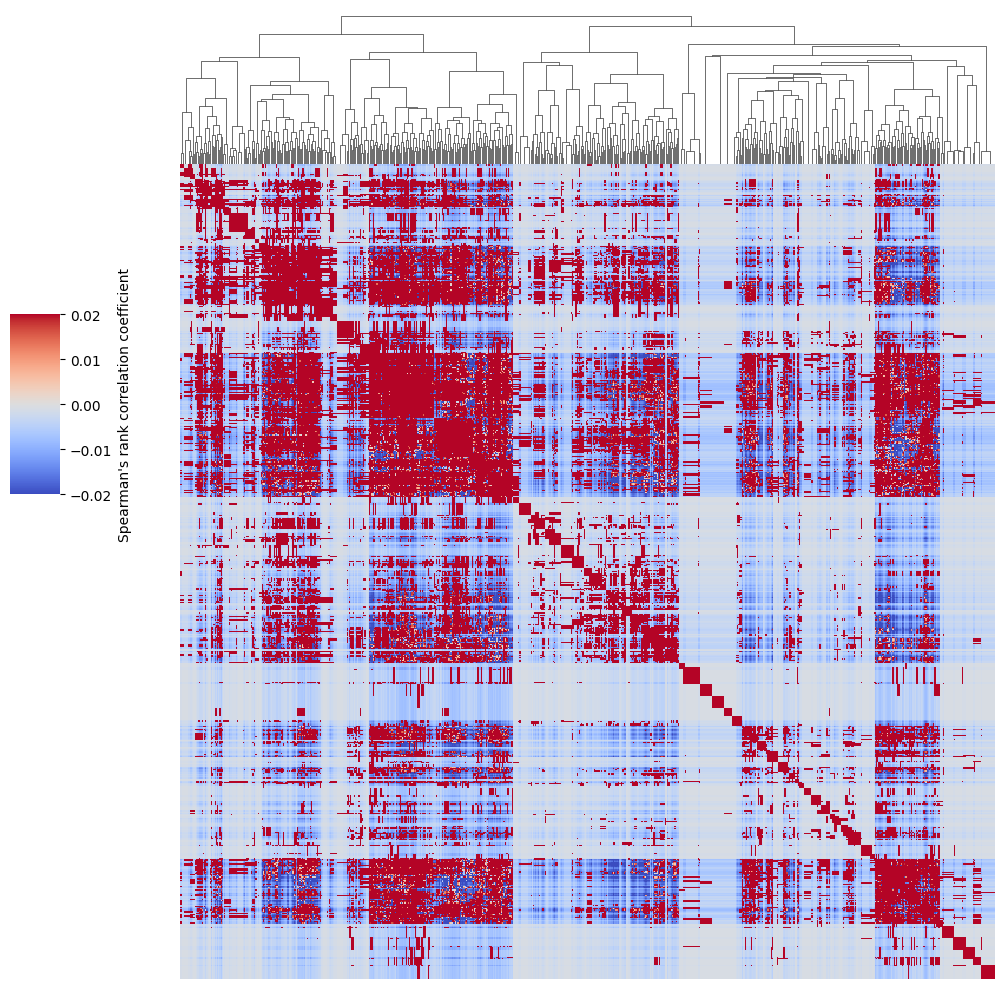

In [18]:
# %%
%matplotlib inline
from scipy.cluster.hierarchy import leaves_list
order = leaves_list(Z)
reordered_corr_matrix = corr_matrix[order, :][:, order]
# Plot the reordered correlation matrix as a clustermap
g = sns.clustermap(
    corr_matrix,
    row_linkage=Z,
    col_linkage=Z,
    cmap='coolwarm',
    center=0,
    vmin=-0.02, vmax=0.02,
    dendrogram_ratio=0.16,
    cbar_pos=(0, 0.5, 0.05, 0.18),
    cbar_kws={'label': "Spearman's rank correlation coefficient"},
    xticklabels=False,
    yticklabels=False,
)

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")
g.ax_row_dendrogram.remove()

clusters = fcluster(Z, t=4, criterion='maxclust')

# Display the plot
plt.savefig('outputs/clustermap.jpg')
plt.show()

In [27]:
# %%
thalamus_cubes_df = pd.DataFrame.from_records(np.array(thalamus_cubes)[valid_indices])
thalamus_cubes_df['cluster'] = clusters
region_img = nib.load(region_output_path)
region_voxels = region_img.get_fdata()
cluster_voxels = region_voxels.copy()
cmap = plt.get_cmap('tab20')
# write on the region_img the clusters of the MD cubes
for cube_idx, cluster in enumerate(clusters):
    x_start, y_start, z_start = thalamus_cubes[valid_indices[cube_idx]]['start']
    x_end, y_end, z_end = thalamus_cubes[valid_indices[cube_idx]]['end']
    rgb = np.array(cmap(cluster)[:3]) * 255
    rgb = rgb.astype(np.uint8)    
    cluster_voxels[x_start:x_end, y_start:y_end, z_start:z_end] = np.sum(rgb)

thalamus_img = nib.Nifti1Image(cluster_voxels, region_img.affine, region_img.header)
nib.save(thalamus_img, 'outputs/thalamus_clusters.nii.gz')

In [26]:
type(thalamus_cubes)



list